In [5]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

# LOG_PATH=Path('/scratch/da2734/twitter/sana/log/')
# DATA_PATH=Path('/scratch/da2734/twitter/sana/data')
# LABEL_PATH=Path('/scratch/da2734/twitter/sana/data/')
# OUTPUT_PATH=Path('/scratch/da2734/twitter/sana/output/')
LOG_PATH=Path('../mturk_mar6/log/')
DATA_PATH=Path('../mturk_mar6/data')
LABEL_PATH=Path('../mturk_mar6/data/')
OUTPUT_PATH=Path('../mturk_mar6/output_100')
FINETUNED_PATH = None

args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "labor_market_classification",
    "no_cuda": False,
#     "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 200,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-uncased',
    "model_type": 'bert'
})

import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

# logger.info(args)

device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

label_cols = ["job_loss","is_unemployed","job_search","is_hired","job_offer"]

# databunch defined here https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
databunch = BertDataBunch(
                        args['data_dir'], 
                        LABEL_PATH, 
                        args.model_name, 
                        train_file='train.csv', 
                        val_file='val.csv',
                        # test_data='test.csv',
                        text_col="text", #this is the name of the column in the train file that containts the tweet text
                        label_col=label_cols,
                        batch_size_per_gpu=args['train_batch_size'], 
                        max_seq_length=args['max_seq_length'], 
                        multi_gpu=args.multi_gpu, 
                        multi_label=True, 
                        model_type=args.model_type)

num_labels = len(databunch.labels)
print('num_labels', num_labels)

# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION')
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# print('Active CUDA Device: GPU', torch.cuda.current_device())

# print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device)

# metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'accuracy', 'function': accuracy})
metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})


learner = BertLearner.from_pretrained_model(
                                            databunch, 
                                            pretrained_path='../mturk_mar6/output_100/model_out/', 
                                            metrics=metrics, 
                                            device=device, 
                                            logger=logger, 
                                            output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, 
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, 
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=0)

print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')



03/20/2020 18:57:52 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/20/2020 18:57:52 - INFO - root -   Loading features from cached file ../mturk_mar6/data/cache/cached_bert_train_multi_label_512_train.csv


/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


03/20/2020 18:57:52 - INFO - root -   Loading features from cached file ../mturk_mar6/data/cache/cached_bert_dev_multi_label_512_val.csv
num_labels 5
03/20/2020 18:57:52 - INFO - transformers.configuration_utils -   loading configuration file ../mturk_mar6/output_100/model_out/config.json
03/20/2020 18:57:52 - INFO - transformers.configuration_utils -   Model config {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [2]:
# from fast_bert.metrics import *
# learner.validate()

In [12]:
val = pd.read_csv('../mturk_mar6/data/val.csv')
print(val.shape)
# start_time = time.time()
texts = val['text'].values.tolist()
print(len(texts))
# print('time taken:', str(time.time() - start_time), 'seconds')
predictions = learner.predict_batch(texts)
# predictions.head()
# predictions_df = pd.DataFrame(predictions)


(737, 7)
737
03/20/2020 19:06:18 - INFO - root -   Writing example 0 of 737


In [16]:
prediction_df = pd.DataFrame(
[dict(prediction) for prediction in predictions],
index=val.id).rename(columns={
'is_unemployed':'is_unemployed_model',
'job_search':'job_search_model',
'is_hired_1mo':'is_hired_1mo_model',
'lost_job_1mo':'lost_job_1mo_model',
'job_offer"':'job_offer_model',
})

# prediction_df

In [17]:
merged = prediction_df.merge(val, on='id')
# merged

is_unemployed filtered time taken: 351.9320418834686 seconds
03/20/2020 19:06:41 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
lost_job_1mo filtered time taken: 352.35536766052246 seconds
03/20/2020 19:06:42 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_search filtered time taken: 352.7885615825653 seconds
03/20/2020 19:06:42 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
is_hired_1mo filtered time taken: 353.206303358078 seconds
03/20/2020 19:06:42 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_offer filtered time taken: 353.6353874206543 seconds
03/20/2020 19:06:43 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


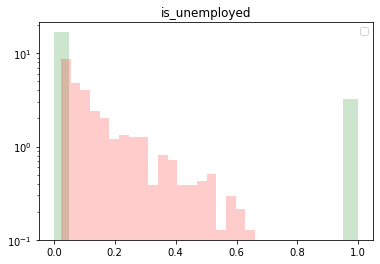

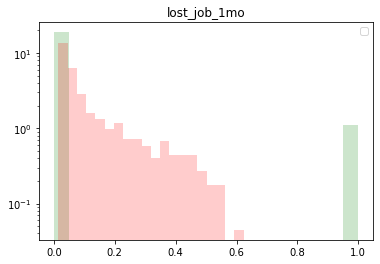

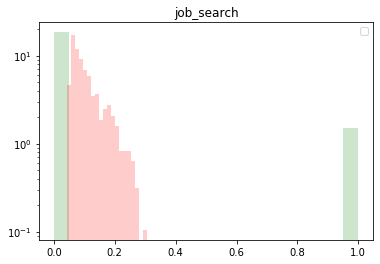

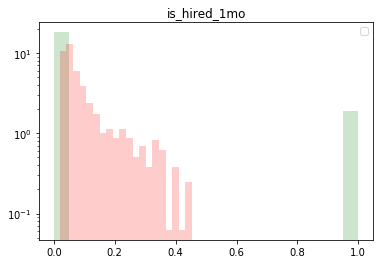

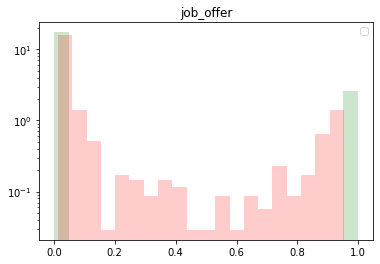

In [18]:
import matplotlib.pyplot as plt
columns = ['is_unemployed', 'lost_job_1mo', 'job_search',
       'is_hired_1mo', 'job_offer']
for column in columns:
#     start_time = time.time()
#     all_filtered_boundary = merged_filtered.loc[(merged_filtered[column] >= threshold - boundary_width) &
#                                                 (merged_filtered[column] <= threshold + boundary_width)]
#     all_filtered_boundary.to_csv('../mturk_mar6/boundary/filtered_{}.csv'.format(column))
    # print(all_filtered_boundary['text'])
    print(column, 'filtered time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged[column], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged[column+'_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()
    #plt.show()
    plt.savefig('../mturk_mar6/boundary_debug/val_{}.png'.format(column))

#     print(column, 'plot filtered time taken:', str(time.time() - start_time), 'seconds')

In [8]:
import pandas as pd
train = pd.read_csv('../mturk_mar6/data/train.csv', sep=',', lineterminator='\n')
print(train.shape)
# start_time = time.time()
texts = train['text'].values.tolist()
print(len(texts))

import time
start_time = time.time()
predictions = learner.predict_batch(texts)
print('time taken:', str(time.time() - start_time), 'seconds')

# predictions.head()
# predictions_df = pd.DataFrame(predictions)

prediction_df = pd.DataFrame(
[dict(prediction) for prediction in predictions],
index=train.id).rename(columns={
'is_unemployed':'is_unemployed_model',
'job_search':'job_search_model',
'is_hired_1mo':'is_hired_1mo_model',
'lost_job_1mo':'lost_job_1mo_model',
'job_offer"':'job_offer_model',
})

print(prediction_df.head())

merged = prediction_df.merge(train, on='id')


(2948, 7)
2948
03/20/2020 19:00:49 - INFO - root -   Writing example 0 of 2948
time taken: 35.383573055267334 seconds
    is_unemployed_model  lost_job_1mo_model  is_hired_1mo_model  \
id                                                                
0   0.690737             0.494194            0.256262             
1   0.610261             0.429157            0.204824             
2   0.651600             0.435135            0.225976             
3   0.262028             0.172028            0.082052             
4   0.598824             0.580993            0.369377             

    job_search_model  job_offer_model  
id                                     
0   0.246235          0.040954         
1   0.249051          0.038123         
2   0.228218          0.036969         
3   0.101327          0.018532         
4   0.281013          0.051514         


is_unemployed filtered time taken: 2227.143659591675 seconds
03/20/2020 19:37:56 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
lost_job_1mo filtered time taken: 2227.192047357559 seconds
03/20/2020 19:37:56 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_search filtered time taken: 2227.2286310195923 seconds
03/20/2020 19:37:56 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
is_hired_1mo filtered time taken: 2227.2633378505707 seconds
03/20/2020 19:37:56 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_offer filtered time taken: 2227.2993264198303 seconds
03/20/2020 19:37:56 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


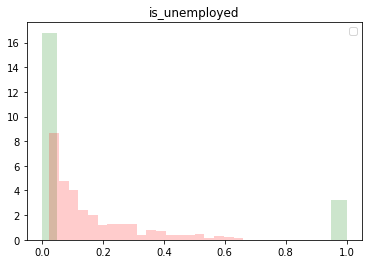

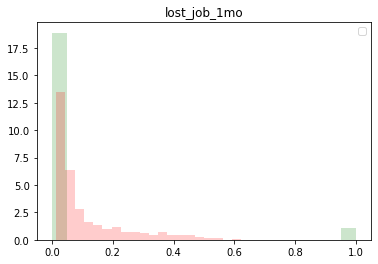

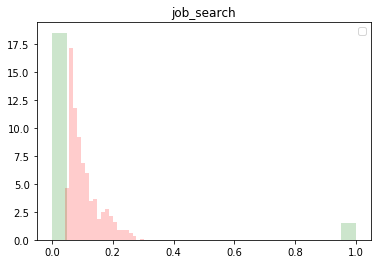

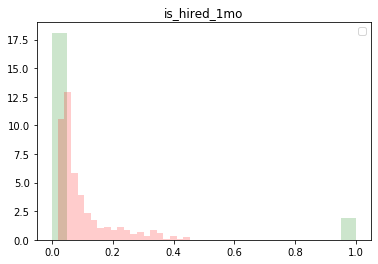

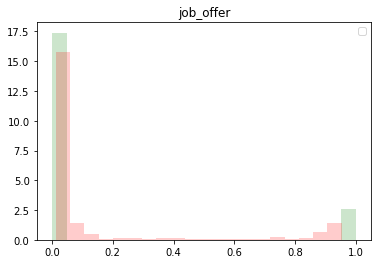

In [19]:
import matplotlib.pyplot as plt
columns = ['is_unemployed', 'lost_job_1mo', 'job_search',
       'is_hired_1mo', 'job_offer']
for column in columns:
#     start_time = time.time()
#     all_filtered_boundary = merged_filtered.loc[(merged_filtered[column] >= threshold - boundary_width) &
#                                                 (merged_filtered[column] <= threshold + boundary_width)]
#     all_filtered_boundary.to_csv('../mturk_mar6/boundary/filtered_{}.csv'.format(column))
    # print(all_filtered_boundary['text'])
    print(column, 'filtered time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged[column], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged[column+'_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()
    #plt.show()
#     plt.savefig('../mturk_mar6/boundary_debug/train_{}.png'.format(column))

#     print(column, 'plot filtered time taken:', str(time.time() - start_time), 'seconds')